# BACQUET Maxime et CARON Mathieu

# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres. Le deuxième exercice mettra en oeuvre une méthode de régression bayésienne linéaire (disponible dans un deuxième notebook).

### Instructions

1. Renommer votre notebook sous la forme `tp2a_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Partie 1 - Metropolis-Hastings

Dans cet exercice, on cherche à générer des échantillons d'une loi appelée *skew-normal* (cf. [Wikipedia](https://en.wikipedia.org/wiki/Skew_normal_distribution)). C'est une loi à support sur $\mathbb{R}$ à trois paramètres : $\alpha \in \mathbb{R}$ (paramètre de skewness), $\xi \in \mathbb{R}$ (paramètre de position), et $\sigma > 0$ (paramètre d'échelle). Dans ce TP nous prendrons $\alpha = 4, \xi = 0, \sigma = 3$.

L'objectif est d'implémenter un algorithme Metropolis-Hastings (MH) avec une loi instrumentale Gaussienne $\mathcal{N}(x_n, \sigma_0^2)$ (i.e., centrée en l'état courant, de variance $\sigma_0^2$).

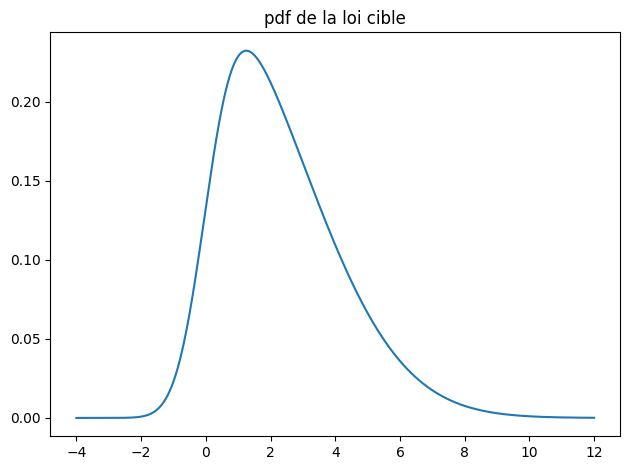

In [3]:
# pdf of the target distribution
a = 4
lc = 0
sc = 3

x = np.linspace(-4,12,500)
y = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)

plt.plot(x,y)
plt.title('pdf de la loi cible')
plt.tight_layout()

**Q1.** Écrire une fonction qui implémente l'algorithme MH proposé, prenant comme arguments :
* La taille de la chaine N
* L'état initial $x_0$
* L'écart-type $\sigma_0$ de la *proposal* gaussienne
* Une graine aléatoire

Pensez à utiliser les fonctions implémentées dans `scipy.stats` pour les pdfs !

In [18]:
def metropolis_hastings(N, x0, s, seed=None):
    """
    Génère une chaîne de Markov en utilisant l'algorithme Metropolis-Hastings.

    Parameters:
    - N (int): Taille de la chaîne.
    - x0 (float): État initial de la chaîne.
    - s (float): Écart-type de la loi instrumentale gaussienne.
    - seed (int, optional): Graine aléatoire pour la reproductibilité.

    Returns:
    - np.ndarray: Chaîne de Markov générée.
    """

    # Initialisation de la graine aléatoire
    np.random.seed(seed)

    # Liste pour stocker les échantillons de la chaîne
    samples = [x0]

    # Génération de la chaîne de Markov dans une boucle
    for _ in range(N - 1):
        current_state = samples[-1]

        # On va maintenant proposer un nouvel échantillon à partir de la loi instrumentale Gaussienne
        proposed_state = np.random.normal(current_state, s)

        # Calculs des densités de probabilité pour l'état actuel et l'état proposé
        current_pdf = ss.skewnorm.pdf(current_state, a, loc=lc, scale=sc)
        proposed_pdf = ss.skewnorm.pdf(proposed_state, a, loc=lc, scale=sc)

        # On peut désormais calculer le rapport de probabilité
        acceptance_ratio = min(1, proposed_pdf / current_pdf)

        # Étape d'acceptation de l'échantillon proposé en fonction du rapport de probabilité
        if np.random.uniform(0, 1) < acceptance_ratio:
            samples.append(proposed_state)
        else:
            samples.append(current_state)

    return np.array(samples)

**Q2**. Prendre $N = 1000, x_0 = 1$. Afficher les *traceplots* (échantillons en fonction de $n$) de la chaine pour des valeurs différentes de $\sigma$ : $0.1, 2, 40$.

Pour chacun des cas, comparer la pdf de la loi cible à une estimation par noyaux de la densité ou un histogramme. Commenter.

In [19]:
# Paramètres
N = 1000
x0 = 1
s_tab = [0.1, 2, 40]

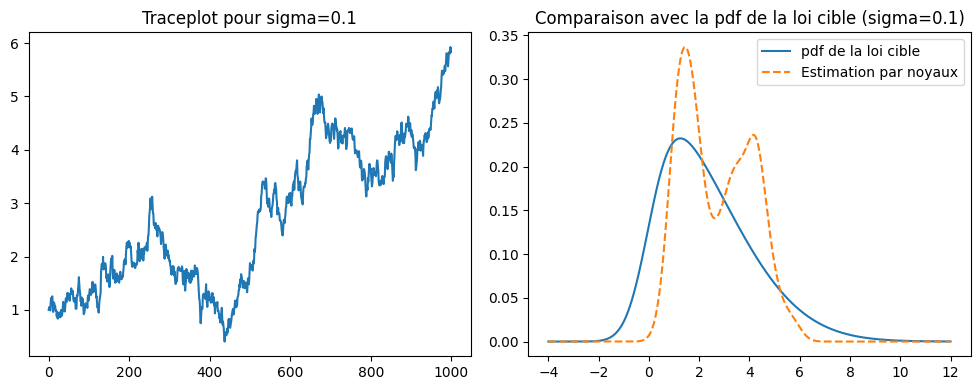

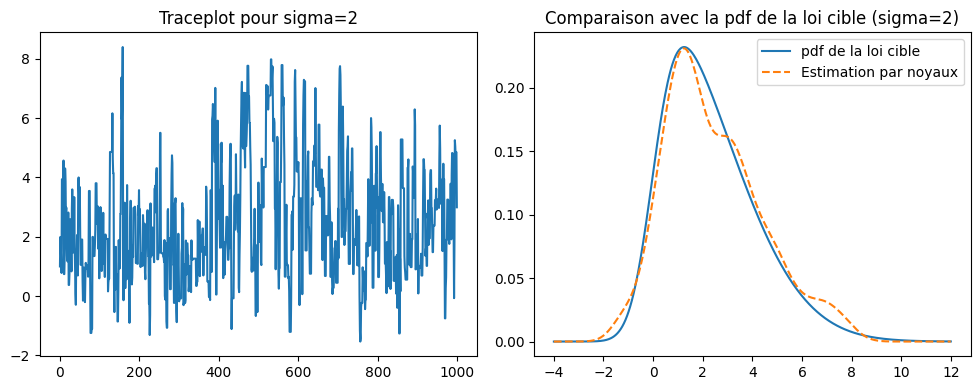

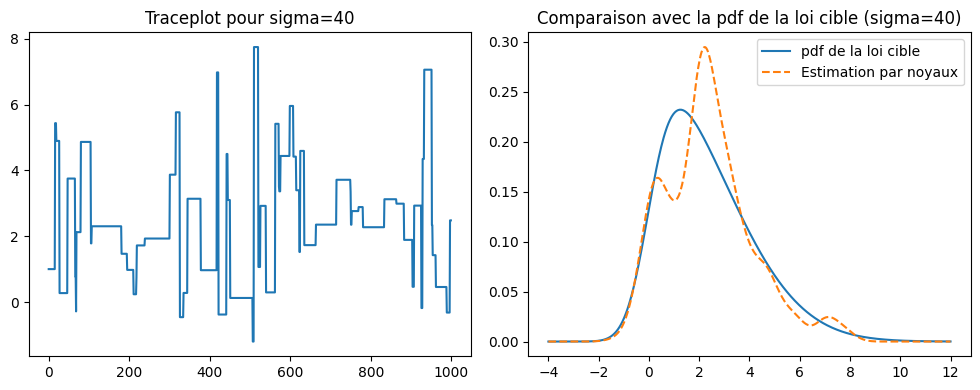

In [20]:
# Traceplots et comparaison avec la pdf de la loi cible

# Boucle sur les sigma à tester
for sigma in s_tab:

    # Génération de la chaîne de Markov avec l'algo q1
    samples = metropolis_hastings(N, x0, sigma, seed=42)

    # Affichage du traceplot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(samples)
    plt.title(f'Traceplot pour sigma={sigma}')

    # Comparaison avec la pdf de la loi cible
    x = np.linspace(-4, 12, 500)
    y_target = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)
    y_estimate = ss.gaussian_kde(samples)(x)

    # Affichage de la pdf de la loi cible et de l'estimation par noyaux
    plt.subplot(1, 2, 2)
    plt.plot(x, y_target, label='pdf de la loi cible')
    plt.plot(x, y_estimate, label='Estimation par noyaux', linestyle='dashed')
    plt.legend()
    plt.title(f'Comparaison avec la pdf de la loi cible (sigma={sigma})')

    plt.tight_layout()
    plt.savefig("img/traceplots_et_comparaison_avec_la_pdf_de_la_loi_cible_pour_differents_sigma.png")
    plt.show()

#### *Traceplots* :

- Pour $\sigma = 0.1$, on observe une chaîne qui explore rapidement l'espace des échantillons (fort taux d'acceptation)
- Pour $\sigma = 2$, on observe que la chaine est moins rapide à explorer que pour $\sigma = 0.1$
- Pour $\sigma = 40$, on observe que la chaine prend des pas relativement grands, conduisant à une exploration plus lente de l'espace des échantillons (fort taux de rejet)

Ainsi $\sigma = 2$ propose un bon compromis. Regardons maintenant la comparaison avec la pdf de la loi cible.

#### *Comparaison avec la pdf de la loi cible* :

On observe une très bonne concordance entre la pdf de la loi cible et l'estimation par noyaux pour $\sigma = 2$.

Pour $\sigma = 40$ et $\sigma = 0.1$, l'estimation par noyaux est moins précise. 

- Pour $\sigma = 0.1$, la chaine a tendance à prendre des pas trop petits et n'explore pas toutes les zones de densité. 
- Pour $\sigma = 40$, la chaîne a une tendance à prendre des pas trop grands et à rater des zones de haute densité de probabilité.

#### *Conclusions* :

On peut en déduire qu'une valeur de $\sigma$ trop petite peut conduire à une exploration inefficace de l'espace.
Une valeur de $\sigma$ trop grande peut conduire à une exploration inefficace de l'espace également, car la chaîne peut sauter rapidement entre les zones de l'espace sans explorer correctement les régions de haute densité. Il faut donc essayer de trouver un bon compromis entre les deux (ici on choisit donc $\sigma = 2$)

**Q3.** Prendre $N = 1000, s = 2$. Afficher les *traceplots* pour $x_0$ valant 0 et 50.

Pour chacun des cas, comparer la pdf de la loi cible à une estimation par noyaux de la densité ou un histogramme. Commenter.

In [21]:
# Paramètres
N = 1000
s = 2
x0_tab = [0, 50]

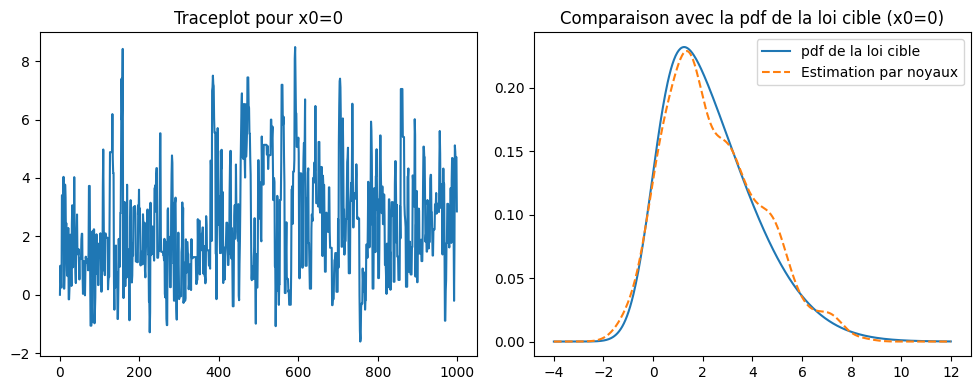

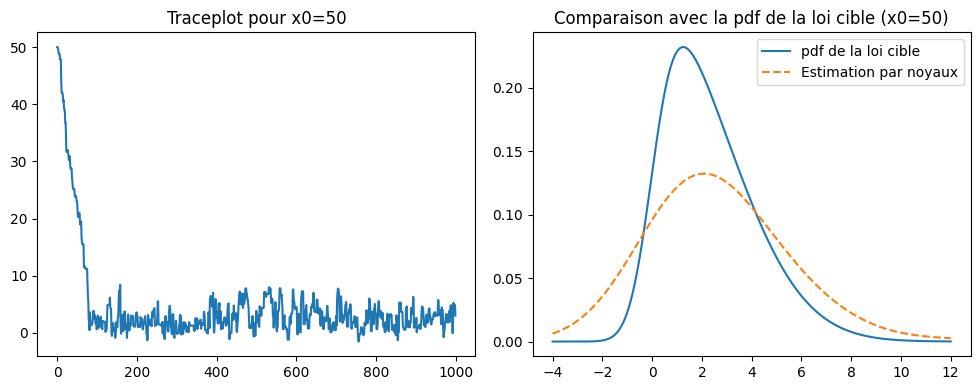

In [22]:
# Traceplots et comparaison avec la pdf de la loi cible

# Boucle sur les deux valeurs de x0 à tester
for x0 in x0_tab:
    
    # Génération de la chaîne de Markov avec l'algo q1
    samples = metropolis_hastings(N, x0, s, seed=42)

    # Affichage du traceplot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(samples)
    plt.title(f'Traceplot pour x0={x0}')

    # Comparaison avec la pdf de la loi cible
    x = np.linspace(-4, 12, 500)
    y_target = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)
    y_estimate = ss.gaussian_kde(samples)(x)

    # Affichage de la pdf de la loi cible et de l'estimation par noyaux
    plt.subplot(1, 2, 2)
    plt.plot(x, y_target, label='pdf de la loi cible')
    plt.plot(x, y_estimate, label='Estimation par noyaux', linestyle='dashed')
    plt.legend()
    plt.title(f'Comparaison avec la pdf de la loi cible (x0={x0})')

    plt.tight_layout()
    plt.savefig("img/traceplots_et_comparaison_avec_la_pdf_de_la_loi_cible_pour_differents_x0.png")
    plt.show()

#### *Traceplots :*

- Pour $x_0 = 0$, on voit qu'on se trouve directement dans les zones de haute densité de probabilité.
- Pour $x_0 = 50$, on s'aperçoit que la chaîne prend un certain temps au début (environ 100 itérations ici) pour se déplacer vers les zones de haute densité de probabilité.

#### *Comparaison avec la pdf de la loi cible* :

On observe une très bonne concordance entre la pdf de la loi cible et l'estimation par noyaux pour $x_0 = 0$.

- Pour $x_0 = 50$, la chaîne met plus de temps à explorer efficacement l'espace (notamment au début). L'estimation par noyaux est donc beaucoup moins précise.

#### *Conclusions* :

Le choix de $x_0$ influence la rapidité avec laquelle la chaîne explore l'espace. Un bon choix initial peut conduire à une convergence plus rapide vers les zones de haute densité. Un $x_0$ trop loin de notre zone de densité de probabilité entraine un temps pendant lequel la chaine de Markov s'ajuste à la distribution cible (rodage). Les échantilons générés ne sont donc pas représentatifs de la distribution cible finale.

Nous pouvons donc supprimer ces premiers echantillons

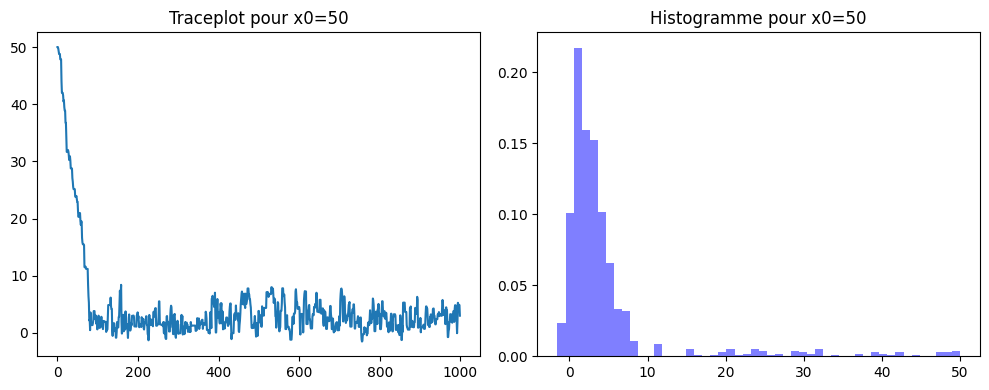

In [30]:
# Pour x_0 = 50
N = 1000
s = 2
x0 = 50

# Génération de la chaîne de Markov avec l'algo q1
samples = metropolis_hastings(N, x0, s, seed=42)

# Affichage du traceplot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(samples)
plt.title(f'Traceplot pour x0={x0}')

# Afficher l'histogramme
plt.subplot(1, 2, 2)
plt.hist(samples, bins=50, density=True, alpha=0.5, color='blue')
plt.title(f'Histogramme pour x0={x0}')

plt.tight_layout()
plt.savefig("img/traceplots_et_histogramme_x0_50_avec_rodage.png")
plt.show()

On voit bien sur l'histogramme que nous avons des pics (au dessus de 10) qui sont très faible qui ne sont pas représentatifs. C'est ce qu'on veut supprimer. Nous allons donc supprimer les 100 premiers échantillons.

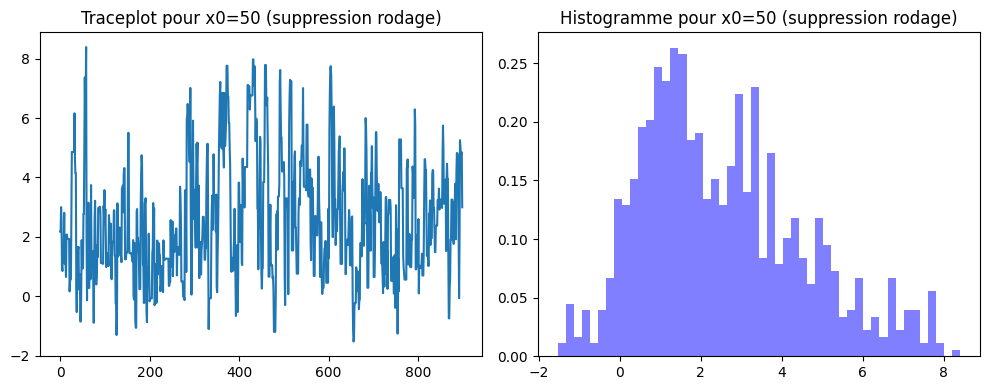

In [31]:
# On peut les 100 premiers
samples = samples[100:]

# Affichage du traceplot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(samples)
plt.title(f'Traceplot pour x0={x0} (suppression rodage)')

# Afficher l'histogramme
plt.subplot(1, 2, 2)
plt.hist(samples, bins=50, density=True, alpha=0.5, color='blue')
plt.title(f'Histogramme pour x0={x0} (suppression rodage)')

plt.tight_layout()
plt.savefig("img/traceplots_et_histogramme_x0_50_suppression_rodage.png")
plt.show()

On voit bien que la distribution est plus représentative ici. Nous pouvons donc comparer avec la pdf de la loi cible :

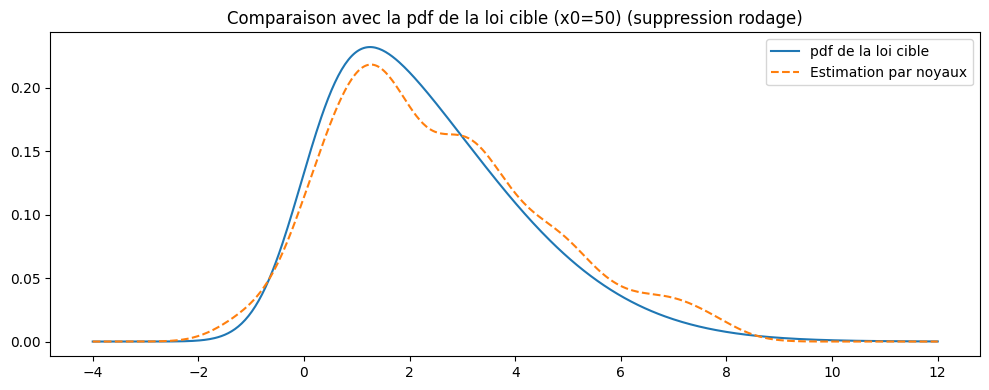

In [32]:
# Comparaison avec la pdf de la loi cible
x = np.linspace(-4, 12, 500)
y_target = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)
y_estimate = ss.gaussian_kde(samples)(x)

# Affichage de la pdf de la loi cible et de l'estimation par noyaux
plt.figure(figsize=(10, 4))
plt.plot(x, y_target, label='pdf de la loi cible')
plt.plot(x, y_estimate, label='Estimation par noyaux', linestyle='dashed')
plt.legend()
plt.title(f'Comparaison avec la pdf de la loi cible (x0={x0}) (suppression rodage)')

plt.tight_layout()
plt.savefig("img/comparaison_avec_la_pdf_de_la_loi_cible_pour_x0_50_suppression_rodage.png")
plt.show()

Notre estimation, cette fois-ci, a une très bonne concordance entre la pdf de la loi cible et l'estimation par noyaux pour $x_0 = 50$ (avec rodage).